In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
from scipy.integrate import solve_ivp
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
import arviz as az
import scipy.stats.kde as kde

# Generate files for stan program

In [2]:
# control parameters
diet = 'Inulin'
abundance_type = 'absolute'
taxonomy_level = 'species'
topN_taxa = 20

In [3]:
# read meta data
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[(df_meta.Diet==diet) | (df_meta.Diet=='Control')]
df_meta['Diet'] = [1 if g==diet else 0 for g in df_meta['Diet']]

# read bacterial absolute abundance
df_bac = pd.read_csv('../../../our_data/16S_%s_abundance_%s.csv'%(abundance_type,taxonomy_level), index_col=0)

# replace unsupported characters with text descriptions
df_bac.columns = [c.replace('/','_slash_').replace(' ','_space_').replace('[','_leftsquarebracket_').replace(']','_rightsquarebracket_').replace('-','_dash_').replace('.','_dot_').replace('(','_leftroundbracket').replace(')','_rightroundbracket_') for c in df_bac.columns]

# replace zeros with minimum non-zero values (since these values will be log-tranformed later)
for sample_id in df_bac.index:
    sample = np.array(df_bac.loc[sample_id])
    minval = np.min(sample[np.nonzero(sample)]) # minimum non-zero value
    sample[sample==0] = minval
    df_bac.loc[sample_id] = sample
df_bac.head()

# select the most abundant species
df_bac_T = df_bac.loc[df_meta.index].T
df_bac_T['mean'] = df_bac_T.mean(axis=1)
df_bac_T = df_bac_T.sort_values(by=['mean'],axis=0,ascending=False)
df_bac_T = df_bac_T.drop('mean', axis=1)
df_bac_topN_taxa = df_bac_T.iloc[0:topN_taxa].T
selected_bacterial_taxa = list(df_bac_topN_taxa.columns)

# normalize max abosolute value to 1
normalization_factor = df_bac_topN_taxa.max().max()
df_bac_topN_taxa = df_bac_topN_taxa/normalization_factor

# merge metadata and bacterial abundance
df_bac_topN_taxa_w_meta = pd.merge(df_meta, df_bac_topN_taxa, left_index=True, right_index=True, how='inner')

# calculate derivative of bacterial abundance
df_deriv = deepcopy(df_bac_topN_taxa_w_meta)
for curr_mice in set(df_deriv.MiceID):
    curr_df = df_deriv[df_deriv.MiceID==curr_mice]
    for taxon in selected_bacterial_taxa:
        xdata = np.array(curr_df['Day'])
        ydata = np.array(curr_df[taxon])
        cs = CubicSpline(xdata, ydata)
        csd1 = cs.derivative(nu=1)
        ydata_d1 = csd1(xdata)
        df_deriv.loc[df_deriv.MiceID==curr_mice, taxon] = ydata_d1

# construct regression matrix (Y~X)
Ymat = df_deriv[selected_bacterial_taxa].values # Ymat should be samples by bacteria
Ymat = Ymat.flatten(order='F')
Ymat = StandardScaler().fit_transform(Ymat.reshape(-1,1)).reshape(1,-1)[0] # standardize

Xmat = np.zeros(shape=(topN_taxa*len(df_deriv.index), (topN_taxa+2)*topN_taxa))
for k in np.arange(topN_taxa):
    Xmat[k*len(df_deriv.index):(k+1)*len(df_deriv.index),k*(topN_taxa+2)] = 1
    Xmat[k*len(df_deriv.index):(k+1)*len(df_deriv.index),k*(topN_taxa+2)+1] = df_deriv.Diet.values
    Xmat[k*len(df_deriv.index):(k+1)*len(df_deriv.index),k*(topN_taxa+2)+2:(k+1)*(topN_taxa+2)] = df_bac_topN_taxa_w_meta[selected_bacterial_taxa].values

# write data file
json_str = '{\n"N" : %d,\n'%(len(Ymat))
json_str += '\"dlogX\" : [%s],\n'%(','.join(list(Ymat.astype(str)))) # y variable
for k1,c1 in enumerate(selected_bacterial_taxa): # x variable
    # growth rate
    json_str += '\"growth_rate_%s\" : [%s],\n'%(c1,','.join(list(Xmat[:,k1*(topN_taxa+2)].astype(str))))
    # diet response
    json_str += '\"inulin_response_%s\" : [%s],\n'%(c1,','.join(list(Xmat[:,k1*(topN_taxa+2)+1].astype(str))))
    # bacterial interactions
    for k2,c2 in enumerate(selected_bacterial_taxa):
        v = list(Xmat[:,k1*(topN_taxa+2)+2+k2].astype(str))
        json_str += '\"pairwise_interaction_%s_%s\" : [%s]'%(c1,c2,','.join(v))
        if c1 == selected_bacterial_taxa[-1] and c2 == selected_bacterial_taxa[-1]:
            json_str += '\n}'
        else:
            json_str += ',\n'

text_file = open("%s_mice_%s_abundance_top%d_%s.data.json"%(diet, abundance_type, topN_taxa, taxonomy_level), "w")
text_file.write("%s" % json_str)
text_file.close()

# write model file
# data block
model_str = 'data {\n'
model_str += '\tint<lower=0> N;\n'
model_str += '\tvector[N] dlogX;\n'
for c1 in selected_bacterial_taxa:
    model_str += '\tvector[N] growth_rate_%s;\n'%(c1)
    model_str += '\tvector[N] inulin_response_%s;\n'%(c1)
    for c2 in selected_bacterial_taxa:
        model_str += '\tvector[N] pairwise_interaction_%s_%s;\n'%(c1,c2)
model_str += '}\n'

# parameter block
model_str += 'parameters {\n\treal<lower=0,upper=1> sigma;\n'
for c1 in selected_bacterial_taxa:
    model_str += '\treal alpha__%s;\n'%(c1) # growth rate
    model_str += '\treal epsilon__%s;\n'%(c1) # inulin response
    for c2 in selected_bacterial_taxa:
        model_str += '\treal beta__%s_%s;\n'%(c1,c2)
model_str += '}\n'       
        
# model block
model_str += 'model {\n\tsigma ~ uniform(0,1);\n'
for c1 in selected_bacterial_taxa:
    model_str += '\talpha__%s ~ normal(0,1);\n'%(c1) # growth rate
    model_str += '\tepsilon__%s ~ normal(0,1);\n'%(c1) # inulin response
    for c2 in selected_bacterial_taxa:
        model_str += '\tbeta__%s_%s ~ normal(0,1);\n'%(c1,c2)
model_str += '\tdlogX ~ normal('
for c1 in selected_bacterial_taxa:
    model_str += 'alpha__%s*growth_rate_%s+'%(c1,c1) # growth rate
    model_str += 'epsilon__%s*inulin_response_%s+'%(c1,c1) # inulin response
    for c2 in selected_bacterial_taxa:
        if c1 == selected_bacterial_taxa[-1] and c2 == selected_bacterial_taxa[-1]:
            model_str += 'beta__%s_%s*pairwise_interaction_%s_%s'%(c1,c2,c1,c2)
        else:
            model_str += 'beta__%s_%s*pairwise_interaction_%s_%s+'%(c1,c2,c1,c2)
model_str += ', sigma);\n}'

text_file = open("%s_mice_%s_abundance_top%d_%s.stan"%(diet, abundance_type, topN_taxa, taxonomy_level), "w")
text_file.write("%s" % model_str)
text_file.close()

# Read stan output and generate summary table

In [5]:
def hpd_grid(sample, alpha=0.05, roundto=2):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI). 
    The function works for multimodal distributions, returning more than one mode
    Parameters
    ----------
    
    sample : Numpy array or python list
        An array containing MCMC samples
    alpha : float
        Desired probability of type I error (defaults to 0.05)
    roundto: integer
        Number of digits after the decimal point for the results
    Returns
    ----------
    hpd: array with the lower 
          
    """
    sample = np.asarray(sample)
    sample = sample[~np.isnan(sample)]
    # get upper and lower bounds
    l = np.min(sample)
    u = np.max(sample)
    density = kde.gaussian_kde(sample)
    x = np.linspace(l, u, 2000)
    y = density.evaluate(x)
    #y = density.evaluate(x, l, u) waitting for PR to be accepted
    xy_zipped = zip(x, y/np.sum(y))
    xy = sorted(xy_zipped, key=lambda x: x[1], reverse=True)
    xy_cum_sum = 0
    hdv = []
    for val in xy:
        xy_cum_sum += val[1]
        hdv.append(val[0])
        if xy_cum_sum >= (1-alpha):
            break
    hdv.sort()
    diff = (u-l)/20  # differences of 5%
    hpd = []
    hpd.append(round(min(hdv), roundto))
    for i in range(1, len(hdv)):
        if hdv[i]-hdv[i-1] >= diff:
            hpd.append(round(hdv[i-1], roundto))
            hpd.append(round(hdv[i], roundto))
    hpd.append(round(max(hdv), roundto))
    ite = iter(hpd)
    hpd = list(zip(ite, ite))
    modes = []
    for value in hpd:
        x_hpd = x[(x > value[0]) & (x < value[1])]
        y_hpd = y[(x > value[0]) & (x < value[1])]
        modes.append(round(x_hpd[np.argmax(y_hpd)], roundto))
    return hpd, x, y, modes

In [13]:
fit = az.from_cmdstan(["stan_output_%d_raw_%s_abundance_top%d_%s.csv"%(i,abundance_type,topN_taxa,taxonomy_level) for i in np.arange(1,4)])

lines = []
    
# basal growth rate
for taxa in selected_bacterial_taxa:
    var = 'alpha__%s'%(taxa)
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior[var][i].values))
    hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
    assert len(hpd_mu) == 1
    (x0, x1) = hpd_mu[0]
    lines.append(['basal_growth_rate', taxa, var, x0, x1, (x0+x1)/2, np.median(data), np.mean(data)/np.std(data), x0*x1>0])
    
# inulin response
for taxa in selected_bacterial_taxa:
    var = 'epsilon__%s'%(taxa)
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior[var][i].values))
    hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
    assert len(hpd_mu) == 1
    (x0, x1) = hpd_mu[0]
    lines.append(['inulin_response', taxa, var, x0, x1, (x0+x1)/2, np.median(data), np.mean(data)/np.std(data), x0*x1>0])

# pairwise interactions
for taxa1 in selected_bacterial_taxa:
    for taxa2 in selected_bacterial_taxa:
        var = 'beta__%s_%s'%(taxa1,taxa2)
        data = []
        for i in np.arange(0,3):
            data.extend(list(fit.posterior[var][i].values))
        hpd_mu, x_mu, y_mu, modes_mu = hpd_grid(data)
        assert len(hpd_mu) == 1
        (x0, x1) = hpd_mu[0]
        lines.append(['pairwise_interaction', (taxa1,taxa2), var, x0, x1, (x0+x1)/2, np.median(data), np.mean(data)/np.std(data), x0*x1>0])
    
df_stan_output_summary = pd.DataFrame(lines, columns = ['Type','Taxa','Variable','Left','Right','Middle','Median','SNR','Significant'])
df_stan_output_summary.to_excel('stan_output_summary_%s_abundance_top%d_%s.xlsx'%(abundance_type,topN_taxa,taxonomy_level))
df_stan_output_summary.head()

,Type,Taxa,Variable,Left,Right,Middle,Median,SNR,Significant
0,basal_growth_rate,Muribaculaceae,alpha__Muribaculaceae,-0.64,0.29,-0.175,-0.182705,-0.768734,False
1,basal_growth_rate,Bacteroides,alpha__Bacteroides,-0.29,0.64,0.175,0.174077,0.732938,False
2,basal_growth_rate,Faecalibaculum,alpha__Faecalibaculum,-0.39,0.55,0.080,0.081533,0.348288,False
3,basal_growth_rate,Bacteroides_dash_acidifaciens,alpha__Bacteroides_dash_acidifaciens,0.39,1.33,0.860,0.859731,3.619062,True
4,basal_growth_rate,Parabacteroides_dash_goldsteinii,alpha__Parabacteroides_dash_goldsteinii,-0.55,0.39,-0.080,-0.085635,-0.361593,False


# Show significant diet responders and species-species interactions

## absolute abundance, top20 species

In [16]:
df_stan_output_summary = pd.read_excel('stan_output_summary_absolute_abundance_top20_species.xlsx', index_col=0)
df_stan_output_summary = df_stan_output_summary[df_stan_output_summary.Significant==True]
df_stan_output_summary

,Type,Taxa,Variable,Left,Right,Middle,Median,SNR,Significant
20,inulin_response,Muribaculaceae,epsilon__Muribaculaceae,1.08,1.62,1.350,1.355570,9.958040,True
21,inulin_response,Bacteroides_dash_acidifaciens,epsilon__Bacteroides_dash_acidifaciens,1.89,2.42,2.155,2.153570,15.846923,True
23,inulin_response,Faecalibaculum,epsilon__Faecalibaculum,0.48,1.01,0.745,0.743532,5.506163,True
24,inulin_response,Parasutterella,epsilon__Parasutterella,0.14,0.68,0.410,0.414614,3.039780,True
25,inulin_response,Bacteroides,epsilon__Bacteroides,0.04,0.58,0.310,0.310039,2.265775,True
40,pairwise_interaction,"('Muribaculaceae', 'Muribaculaceae')",beta__Muribaculaceae_Muribaculaceae,-1.59,-0.29,-0.940,-0.942510,-2.864951,True
41,pairwise_interaction,"('Muribaculaceae', 'Bacteroides_dash_acidifaci...",beta__Muribaculaceae_Bacteroides_dash_acidifac...,0.23,2.31,1.270,1.258725,2.392931,True
51,pairwise_interaction,"('Muribaculaceae', 'Desulfovibrionaceae')",beta__Muribaculaceae_Desulfovibrionaceae,0.27,3.71,1.990,2.003750,2.280134,True
52,pairwise_interaction,"('Muribaculaceae', 'Clostridia_dash_UCG_dash_0...",beta__Muribaculaceae_Clostridia_dash_UCG_dash_014,-3.74,-0.06,-1.900,-1.877020,-2.016358,True
60,pairwise_interaction,"('Bacteroides_dash_acidifaciens', 'Muribaculac...",beta__Bacteroides_dash_acidifaciens_Muribacula...,-3.81,-2.50,-3.155,-3.146940,-9.603366,True


## absolute abundance, top10 species

In [17]:
df_stan_output_summary = pd.read_excel('stan_output_summary_absolute_abundance_top10_species.xlsx', index_col=0)
df_stan_output_summary = df_stan_output_summary[df_stan_output_summary.Significant==True]
df_stan_output_summary

,Type,Taxa,Variable,Left,Right,Middle,Median,SNR,Significant
10,inulin_response,Muribaculaceae,epsilon__Muribaculaceae,0.70,1.23,0.965,0.969487,7.203249,True
11,inulin_response,Bacteroides_dash_acidifaciens,epsilon__Bacteroides_dash_acidifaciens,1.28,1.82,1.550,1.546165,11.381148,True
13,inulin_response,Faecalibaculum,epsilon__Faecalibaculum,0.27,0.80,0.535,0.534336,3.951321,True
14,inulin_response,Parasutterella,epsilon__Parasutterella,0.03,0.56,0.295,0.297743,2.223540,True
20,pairwise_interaction,"('Muribaculaceae', 'Muribaculaceae')",beta__Muribaculaceae_Muribaculaceae,-1.38,-0.09,-0.735,-0.733335,-2.255847,True
30,pairwise_interaction,"('Bacteroides_dash_acidifaciens', 'Muribaculac...",beta__Bacteroides_dash_acidifaciens_Muribacula...,-2.96,-1.67,-2.315,-2.313475,-7.119429,True
32,pairwise_interaction,"('Bacteroides_dash_acidifaciens', 'Akkermansia...",beta__Bacteroides_dash_acidifaciens_Akkermansi...,-3.81,-1.01,-2.410,-2.411280,-3.402103,True
33,pairwise_interaction,"('Bacteroides_dash_acidifaciens', 'Faecalibacu...",beta__Bacteroides_dash_acidifaciens_Faecalibac...,-3.56,-0.30,-1.930,-1.904400,-2.300717,True
35,pairwise_interaction,"('Bacteroides_dash_acidifaciens', 'Bacteroides')",beta__Bacteroides_dash_acidifaciens_Bacteroides,-4.78,-1.31,-3.045,-3.031550,-3.433229,True
50,pairwise_interaction,"('Faecalibaculum', 'Muribaculaceae')",beta__Faecalibaculum_Muribaculaceae,-1.45,-0.19,-0.820,-0.826497,-2.567969,True


## relative abundance, top20 species

In [18]:
df_stan_output_summary = pd.read_excel('stan_output_summary_relative_abundance_top20_species.xlsx', index_col=0)
df_stan_output_summary = df_stan_output_summary[df_stan_output_summary.Significant==True]
df_stan_output_summary

,Type,Taxa,Variable,Left,Right,Middle,Median,SNR,Significant
3,basal_growth_rate,Bacteroides_dash_acidifaciens,alpha__Bacteroides_dash_acidifaciens,0.39,1.33,0.860,0.859731,3.619062,True
22,inulin_response,Faecalibaculum,epsilon__Faecalibaculum,0.63,1.22,0.925,0.923859,6.199610,True
23,inulin_response,Bacteroides_dash_acidifaciens,epsilon__Bacteroides_dash_acidifaciens,2.02,2.60,2.310,2.313010,15.578801,True
25,inulin_response,Parasutterella,epsilon__Parasutterella,0.21,0.80,0.505,0.503716,3.377636,True
28,inulin_response,Alloprevotella,epsilon__Alloprevotella,-0.93,-0.34,-0.635,-0.637676,-4.281057,True
31,inulin_response,Desulfovibrionaceae,epsilon__Desulfovibrionaceae,-0.91,-0.32,-0.615,-0.613235,-4.114519,True
37,inulin_response,Alistipes,epsilon__Alistipes,-0.60,-0.01,-0.305,-0.305510,-2.046231,True
38,inulin_response,Helicobacter_dash_ganmani,epsilon__Helicobacter_dash_ganmani,-0.60,-0.01,-0.305,-0.298658,-2.003188,True
40,pairwise_interaction,"('Muribaculaceae', 'Muribaculaceae')",beta__Muribaculaceae_Muribaculaceae,0.11,1.44,0.775,0.775844,2.317362,True
51,pairwise_interaction,"('Muribaculaceae', 'Desulfovibrionaceae')",beta__Muribaculaceae_Desulfovibrionaceae,0.37,2.96,1.665,1.678860,2.552528,True


# Plot posterior distribution of inulin responders

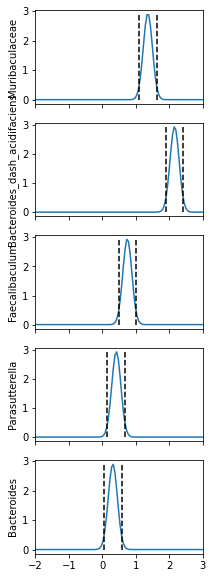

In [29]:
fit = az.from_cmdstan(["stan_output_%d_raw_absolute_abundance_top20_species.csv"%(i) for i in np.arange(1,4)])

# find inulin responders
df_stan_output_summary = pd.read_excel('stan_output_summary_absolute_abundance_top20_species.xlsx', index_col=0)
df_stan_output_summary = df_stan_output_summary[df_stan_output_summary.Significant==True].reset_index(drop=True)
df_stan_output_summary = df_stan_output_summary[df_stan_output_summary.Type=='inulin_response']

# plot
fig, ax = plt.subplots(figsize=(3,10), nrows=len(df_stan_output_summary.index), ncols=1, sharex=True)

for idx in df_stan_output_summary.index:
    _type = df_stan_output_summary.loc[idx,'Type']
    _taxa = df_stan_output_summary.loc[idx,'Taxa']
    _left = df_stan_output_summary.loc[idx,'Left']
    _middle = df_stan_output_summary.loc[idx,'Middle']
    _right = df_stan_output_summary.loc[idx,'Right']
    if _type == 'inulin_response':
        var = 'epsilon__%s'%(_taxa)
    if _type == 'pairwise_interaction':
        var = 'beta__%s_%s'%(eval(_taxa)[0],eval(_taxa)[1])
    data = []
    for i in np.arange(0,3):
        data.extend(list(fit.posterior[var][i].values))
    mean,std=norm.fit(data)
    x = np.linspace(-2, 3, 100)
    ax[idx].set_xlim([-2,3])
    y = norm.pdf(x, mean, std)
    ax[idx].plot(x,y)
    ax[idx].plot([_left,_left],[0,np.max(y)], 'k--')
    ax[idx].plot([_right,_right],[0,np.max(y)], 'k--')
    ax[idx].set_ylabel(_taxa)
    
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("posterior_distribution_inulin_responders_absolute_abundance_top20_species.svg", format="svg")

# Plot relative abundance of 5 inulin responders on log scale

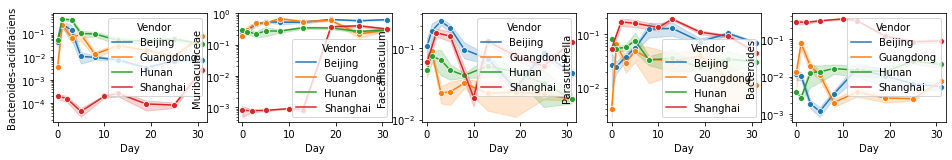

In [40]:
inulin_responders = ['Bacteroides-acidifaciens','Muribaculaceae','Faecalibaculum','Parasutterella','Bacteroides']
fig, ax = plt.subplots(figsize=(16,2), nrows=1, ncols=len(inulin_responders))

df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin']
df_bac = pd.read_csv('../../../our_data/16S_relative_abundance_species.csv', index_col=0)
df_meta_bac = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

for k,ir in enumerate(inulin_responders):
    sns.lineplot(x='Day',y=ir, marker='o', hue='Vendor', ci=68, data=df_meta_bac, ax=ax[k])
    ax[k].set_xlim([-1,32])
    ax[k].set_yscale('log')

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("time_series_inulin_responder_relative_abundance_log_scale.svg", format="svg")

# Plot absolute abundance of 5 inulin responders on linear scale

## plot different responders in separate graphs

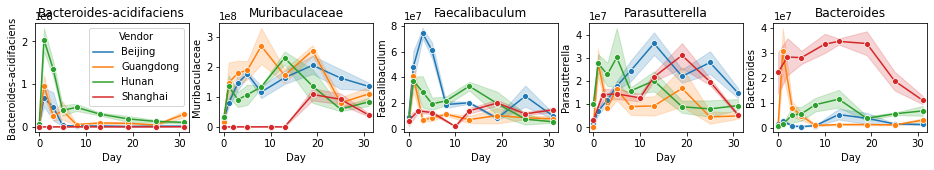

In [63]:
inulin_responders = ['Bacteroides-acidifaciens','Muribaculaceae','Faecalibaculum','Parasutterella','Bacteroides']
fig, ax = plt.subplots(figsize=(16,2), nrows=1, ncols=len(inulin_responders))

df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin']
df_bac = pd.read_csv('../../../our_data/16S_absolute_abundance_species.csv', index_col=0)
df_meta_bac = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

for k,ir in enumerate(inulin_responders):
    sns.lineplot(x='Day',y=ir, marker='o', hue='Vendor', ci=68, data=df_meta_bac, ax=ax[k])
    ax[k].set_xlim([-1,32])
    ax[k].set_title(ir)
    if k!=0:
        ax[k].legend().remove()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("time_series_inulin_responder_separate_graph_absolute_abundance_linear_scale.svg", format="svg")

## plot different responders in the same graph

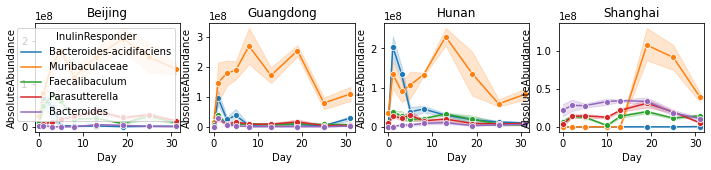

In [62]:
fig, ax = plt.subplots(figsize=(12,2), nrows=1, ncols=4)

df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin']
df_bac = pd.read_csv('../../../our_data/16S_absolute_abundance_species.csv', index_col=0)
df_meta_bac = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

inulin_responders = ['Bacteroides-acidifaciens','Muribaculaceae','Faecalibaculum','Parasutterella','Bacteroides']
for k,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    df_tmp = df_meta_bac.loc[df_meta_bac.Vendor==vendor,['Day']+inulin_responders].set_index('Day').unstack().reset_index()
    df_tmp.columns = ['InulinResponder','Day','AbsoluteAbundance']
    sns.lineplot(x='Day',y='AbsoluteAbundance', marker='o', hue='InulinResponder', ci=68, data=df_tmp, ax=ax[k])
    ax[k].set_title(vendor)
    ax[k].set_xlim([-1,32])
    if k!=0:
        ax[k].legend().remove()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("time_series_inulin_responder_same_graph_absolute_abundance_linear_scale.svg", format="svg")

## plot total relative abundance of all responders

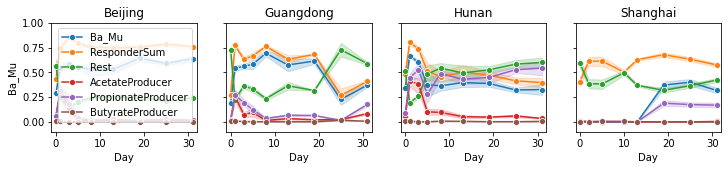

In [9]:
fig, ax = plt.subplots(figsize=(12,2), nrows=1, ncols=4, sharex=True, sharey=True)

df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin']
df_bac = pd.read_csv('../../../our_data/16S_relative_abundance_species.csv', index_col=0)
df_meta_bac = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')
df_producer = pd.read_csv('../../figure5_scfa_prediction/inulin/feature_importance.csv', index_col=0)

inulin_responders = ['Bacteroides-acidifaciens','Muribaculaceae','Faecalibaculum','Parasutterella','Bacteroides']
for k,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    df_tmp = df_meta_bac.loc[df_meta_bac.Vendor==vendor].set_index('Day',drop=True).drop(['Vendor','MiceID','Diet','RandomizedGroup'], axis=1)
    df_tmp['Rest'] = df_tmp[[c for c in df_tmp.columns if c not in inulin_responders]].sum(axis=1) # do this first
    df_tmp['Ba_Mu'] = df_tmp[['Bacteroides-acidifaciens','Muribaculaceae']].sum(axis=1)
    df_tmp['AcetateProducer'] = df_tmp[[c for c in df_tmp.columns if c in list(df_producer.loc[df_producer.SCFA=='Acetate','Species'])]].sum(axis=1)
    df_tmp['ButyrateProducer'] = df_tmp[[c for c in df_tmp.columns if c in list(df_producer.loc[df_producer.SCFA=='Butyrate','Species'])]].sum(axis=1)
    df_tmp['PropionateProducer'] = df_tmp[[c for c in df_tmp.columns if c in list(df_producer.loc[df_producer.SCFA=='Propionate','Species'])]].sum(axis=1)
    df_tmp['ResponderSum'] = df_tmp[inulin_responders].sum(axis=1)
    for r in ['Ba_Mu','ResponderSum','Rest','AcetateProducer','PropionateProducer','ButyrateProducer']:
        sns.lineplot(x='Day',y=r, marker='o', ci=68, data=df_tmp.reset_index(), ax=ax[k], label=r)
    ax[k].set_title(vendor)
    ax[k].set_xlim([-1,32])
    ax[k].set_xticks([0,10,20,30])
    ax[k].set_ylim([-0.1,1])
    if k!=0:
        ax[k].legend().remove()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("time_series_inulin_responder_total_relative_abundance.svg", format="svg")

## plot total absolute abundance of all responders

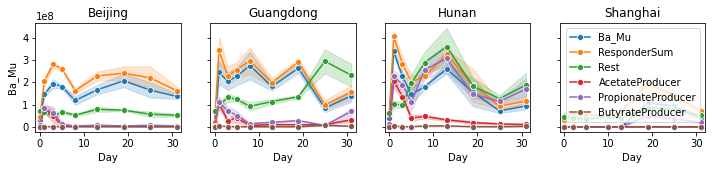

In [8]:
fig, ax = plt.subplots(figsize=(12,2), nrows=1, ncols=4, sharex=True, sharey=True)

df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin']
df_bac = pd.read_csv('../../../our_data/16S_absolute_abundance_species.csv', index_col=0)
df_meta_bac = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')
df_producer = pd.read_csv('../../figure5_scfa_prediction/inulin/feature_importance.csv', index_col=0)

inulin_responders = ['Bacteroides-acidifaciens','Muribaculaceae','Faecalibaculum','Parasutterella','Bacteroides']
for k,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    df_tmp = df_meta_bac.loc[df_meta_bac.Vendor==vendor].set_index('Day',drop=True).drop(['Vendor','MiceID','Diet','RandomizedGroup'], axis=1)
    df_tmp['Rest'] = df_tmp[[c for c in df_tmp.columns if c not in inulin_responders]].sum(axis=1) # do this first
    df_tmp['Ba_Mu'] = df_tmp[['Bacteroides-acidifaciens','Muribaculaceae']].sum(axis=1)
    df_tmp['AcetateProducer'] = df_tmp[[c for c in df_tmp.columns if c in list(df_producer.loc[df_producer.SCFA=='Acetate','Species'])]].sum(axis=1)
    df_tmp['ButyrateProducer'] = df_tmp[[c for c in df_tmp.columns if c in list(df_producer.loc[df_producer.SCFA=='Butyrate','Species'])]].sum(axis=1)
    df_tmp['PropionateProducer'] = df_tmp[[c for c in df_tmp.columns if c in list(df_producer.loc[df_producer.SCFA=='Propionate','Species'])]].sum(axis=1)
    df_tmp['ResponderSum'] = df_tmp[inulin_responders].sum(axis=1)
    for r in ['Ba_Mu','ResponderSum','Rest','AcetateProducer','PropionateProducer','ButyrateProducer']:
        sns.lineplot(x='Day',y=r, marker='o', ci=68, data=df_tmp.reset_index(), ax=ax[k], label=r)
    ax[k].set_title(vendor)
    ax[k].set_xlim([-1,32])
    ax[k].set_xticks([0,10,20,30])
    if k!=3:
        ax[k].legend().remove()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("time_series_inulin_responder_total_absolute_abundance.svg", format="svg")

# Compare data and simulations

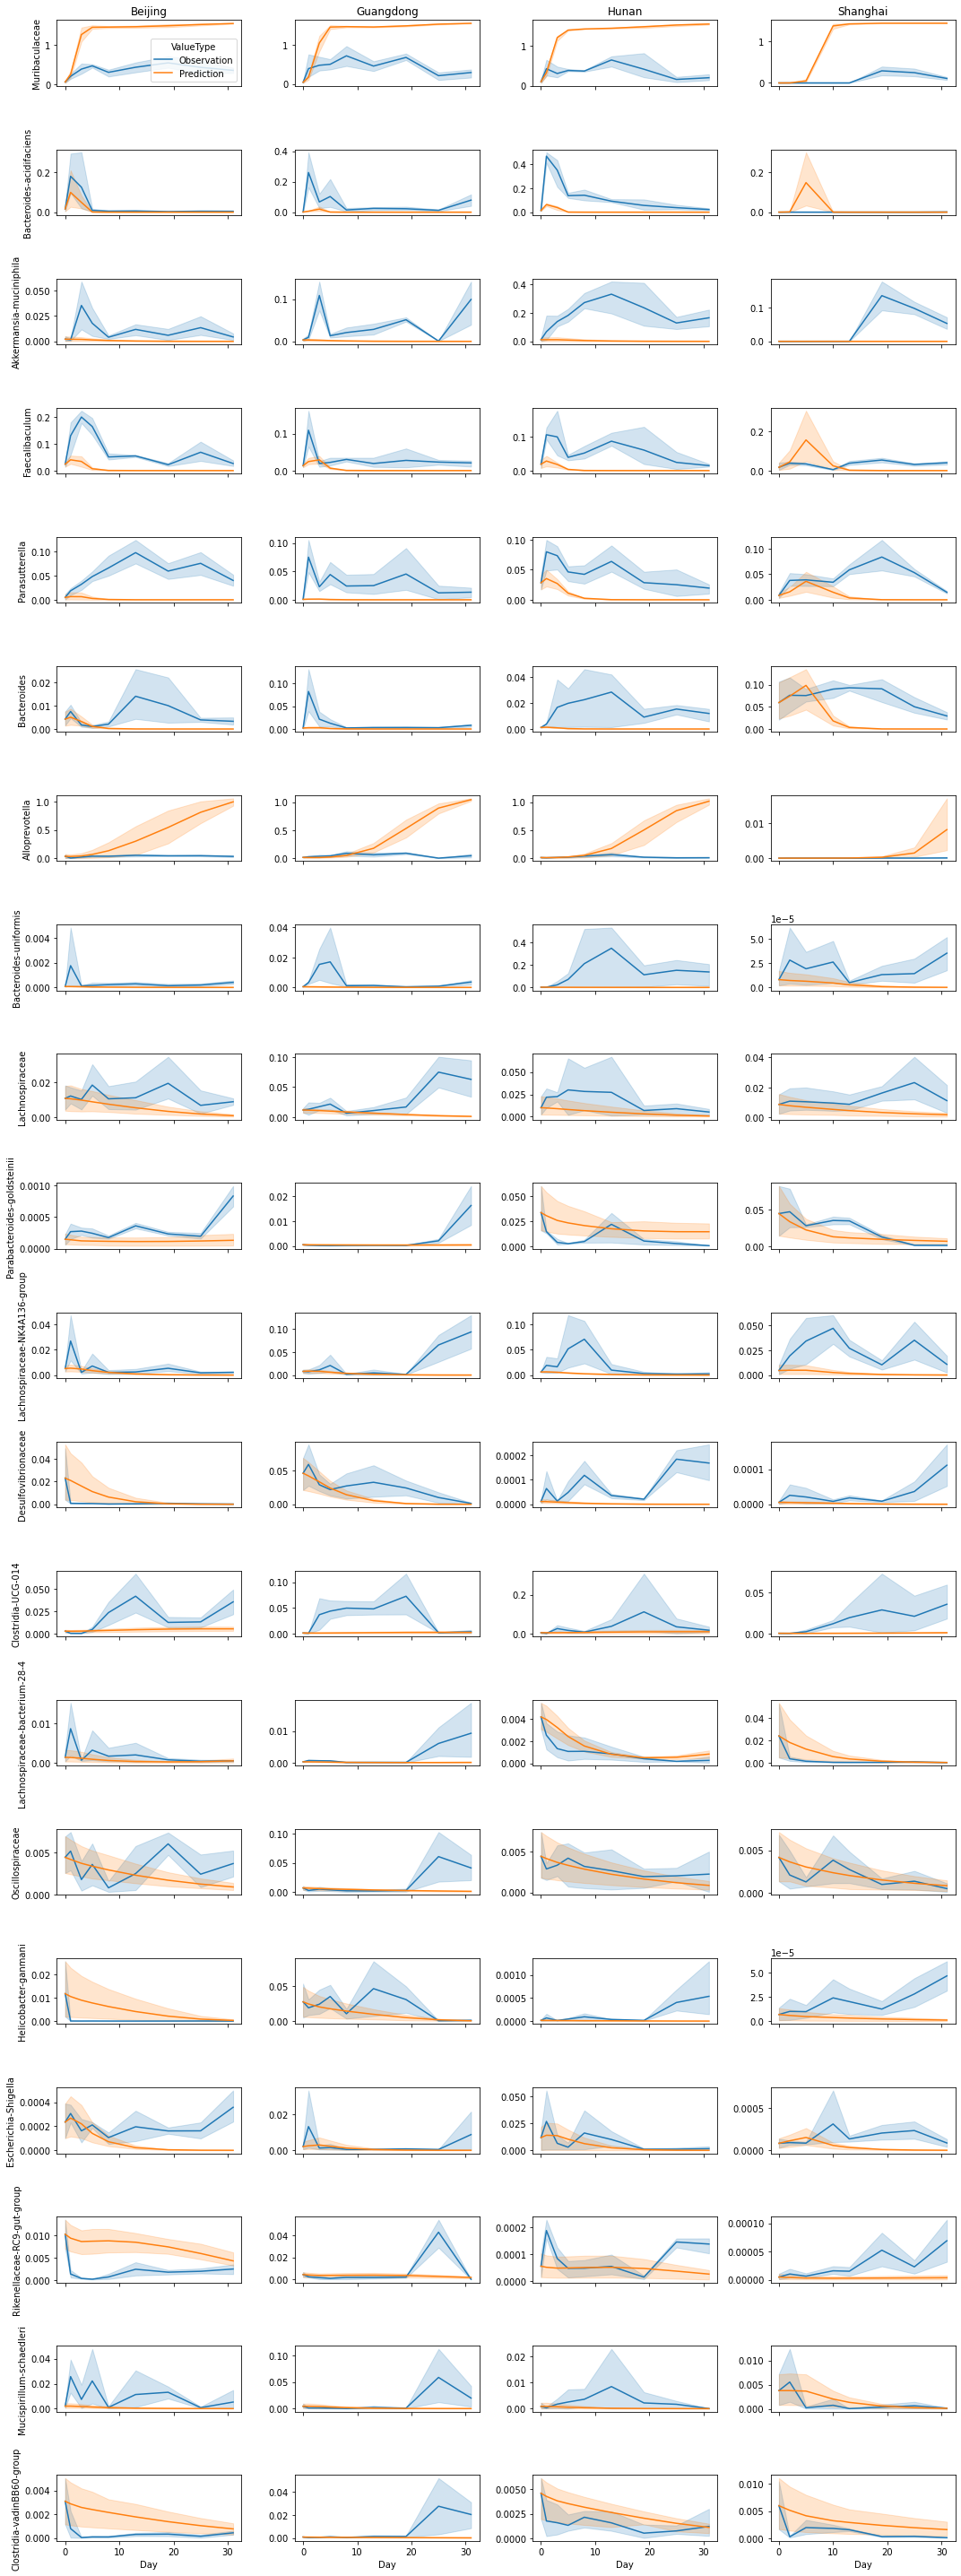

In [28]:
def gLV(t, y, bacterial_taxa, params):
    
    # check if y<0
    ypos = [m if m>0 else 0 for m in deepcopy(y)]
    
    deriv = []
    for k1,c1 in enumerate(selected_bacterial_taxa):
        growth_rate_var = 'alpha__%s'%(c1)
        diet_response_var = 'epsilon__%s'%(c1)
        dc1_dt = params[growth_rate_var]+params[diet_response_var]
        for k2,c2 in enumerate(selected_bacterial_taxa):
            pairwise_interaction_var = 'beta__%s_%s'%(c1,c2)
            dc1_dt += params[pairwise_interaction_var]*ypos[k2]
        deriv.append(dc1_dt*ypos[k1])
    return deriv
 
df_stan_output_summary = pd.read_excel('stan_output_summary_absolute_abundance_top20_species.xlsx', index_col=0)
params = dict(zip(df_stan_output_summary.Variable,df_stan_output_summary.Median))
df_bac_topN_taxa_w_meta = df_bac_topN_taxa_w_meta[df_bac_topN_taxa_w_meta.Diet==1] # just inulin

# solve the model
all_mice = set(df_bac_topN_taxa_w_meta.MiceID)
xcorr = np.linspace(0,31,311)
df_obs_pred = None
for curr_mice in all_mice:
    curr_df = df_bac_topN_taxa_w_meta[df_bac_topN_taxa_w_meta.MiceID==curr_mice]
    init_conc = list(curr_df.loc[curr_df.Day==0,selected_bacterial_taxa].values)[0]
    # sol.t, sol.y (# number of taxa x numberr of time point)
    sol = solve_ivp(gLV, [0,31], init_conc, args=(selected_bacterial_taxa,params), method='BDF', t_eval=xcorr)
    
    # HI4 is unstable in simulation and solver returns simulated value for only partial time points
    if np.abs(np.max(sol.t)-xcorr[-1])<1e-6:
        # get a copy of curr_df but replace observed values with simulated values
        curr_df_pred = deepcopy(curr_df)
        for k,t in enumerate(selected_bacterial_taxa):
            cs = CubicSpline(sol.t, sol.y[k])
            curr_df_pred[t] = cs(curr_df_pred.Day)

        # add column to indicate observation or prediction
        curr_df['ValueType'] = 'Observation'
        curr_df_pred['ValueType'] = 'Prediction'
    
        if df_obs_pred is None:
            df_obs_pred = pd.concat([curr_df, curr_df_pred], ignore_index=True)
        else:
            df_obs_pred = pd.concat([df_obs_pred, curr_df, curr_df_pred], ignore_index=True)

# plot
fig, ax = plt.subplots(nrows=20, ncols=4, figsize=(15,40), sharex=True)
for j,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    for i,t in enumerate(selected_bacterial_taxa):
        _ = sns.lineplot(x='Day', y=t, hue='ValueType', data=df_obs_pred[df_obs_pred.Vendor==vendor], ax=ax[i,j])
        if i!=0 or j!=0:
            ax[i,j].legend().remove()
        ax[i,j].set_ylabel(t)
        if i==0:
            ax[i,j].set_title(vendor)
        
        if j==0:
            ax[i,j].set_ylabel(t.replace('_slash_','/').replace('_space_',' ').replace('_leftsquarebracket_','[').replace('_rightsquarebracket_',']').replace('_dash_','-').replace('_dot_','.').replace('_leftroundbracket','(').replace('_rightroundbracket_',')'))
        else:
            ax[i,j].set_ylabel('')
plt.tight_layout()

# Simulate effects of removing B. acidifaciens and Muribaculaceae

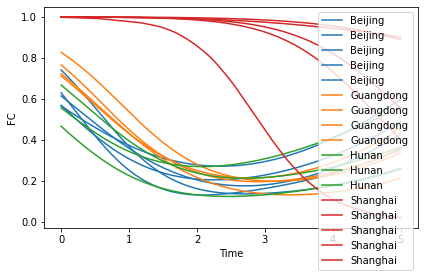

In [40]:
def gLV(t, y, bacterial_taxa, params):
    
    # check if y<0
    ypos = [m if m>0 else 0 for m in deepcopy(y)]
    
    deriv = []
    for k1,c1 in enumerate(selected_bacterial_taxa):
        growth_rate_var = 'alpha__%s'%(c1)
        diet_response_var = 'epsilon__%s'%(c1)
        dc1_dt = params[growth_rate_var]+params[diet_response_var]
        for k2,c2 in enumerate(selected_bacterial_taxa):
            pairwise_interaction_var = 'beta__%s_%s'%(c1,c2)
            dc1_dt += params[pairwise_interaction_var]*ypos[k2]
        deriv.append(dc1_dt*ypos[k1])
    return deriv
 
df_stan_output_summary = pd.read_excel('stan_output_summary_absolute_abundance_top20_species.xlsx', index_col=0)
params = dict(zip(df_stan_output_summary.Variable,df_stan_output_summary.Median))
df_bac_topN_taxa_w_meta = df_bac_topN_taxa_w_meta[df_bac_topN_taxa_w_meta.Diet==1] # just inulin

# solve the model
all_mice = df_bac_topN_taxa_w_meta[['MiceID','Vendor']].drop_duplicates().sort_values(by='Vendor').MiceID
xcorr = np.linspace(0,5,300)
lines = []
for curr_mice in all_mice:
    curr_df = df_bac_topN_taxa_w_meta[df_bac_topN_taxa_w_meta.MiceID==curr_mice]
    vendor = list(set(curr_df['Vendor']))[0]
    
    # intact baseline
    init_conc1 = list(curr_df.loc[curr_df.Day==0,selected_bacterial_taxa].values)[0]
    sol1 = solve_ivp(gLV, [0,5], init_conc1, args=(selected_bacterial_taxa,params), method='BDF', t_eval=xcorr)
    
    # perturbed baseline
    init_conc2 = list(curr_df.loc[curr_df.Day==0,selected_bacterial_taxa].values)[0]
    init_conc2[selected_bacterial_taxa.index('Muribaculaceae')] = 0
    init_conc2[selected_bacterial_taxa.index('Bacteroides_dash_acidifaciens')] = 0
    sol2 = solve_ivp(gLV, [0,5], init_conc2, args=(selected_bacterial_taxa,params), method='BDF', t_eval=xcorr)
    
    #print(curr_mice, vendor, sol1.t[-1], sol2.t[-1])
    # HI4 is unstable in simulation and solver returns simulated value for only partial time points
    if np.abs(np.max(sol1.t)-xcorr[-1])<1e-6 and np.abs(np.max(sol2.t)-xcorr[-1])<1e-6:
        sol1_total = sol1.t*0
        sol2_total = sol2.t*0
        for k,taxa in enumerate(selected_bacterial_taxa):
            sol1_total += sol1.y[k]
            sol2_total += sol2.y[k]
        density_ratio = sol2_total/sol1_total
        for k,v in zip(sol1.t, density_ratio):
            lines.append([curr_mice, vendor, k, v])
        
df_remove_Ba_Mu = pd.DataFrame(lines, columns=['MiceID','Vendor','Time','FC'])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for k,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    df_tmp = df_remove_Ba_Mu[df_remove_Ba_Mu.Vendor==vendor]
    for mice in set(df_tmp.MiceID):
        df_tmp2 = df_tmp[df_tmp.MiceID==mice]
        _ = sns.lineplot(x='Time', y='FC', data=df_tmp2, color=colors[k], ax=ax, label=vendor)
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("simulated_absolute_abundance_fold_change_remove_Ba_Mu.svg", format="svg")

# Simulate effects of removing positive outgoing links of B. acidaficiens and Muribaculaceae

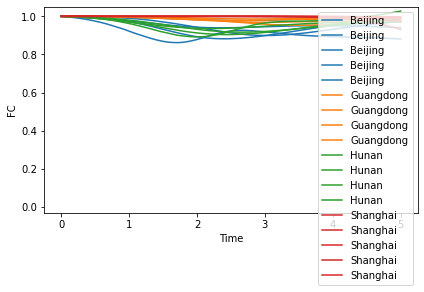

In [43]:
def gLV(t, y, bacterial_taxa, params, flag):
    
    # check if y<0
    ypos = [m if m>0 else 0 for m in deepcopy(y)]
    
    deriv = []
    for k1,c1 in enumerate(selected_bacterial_taxa):
        growth_rate_var = 'alpha__%s'%(c1)
        diet_response_var = 'epsilon__%s'%(c1)
        dc1_dt = params[growth_rate_var]+params[diet_response_var]
        for k2,c2 in enumerate(selected_bacterial_taxa):
            pairwise_interaction_var = 'beta__%s_%s'%(c1,c2)
            coef = params[pairwise_interaction_var]
            
            # only remove positive links from Ba or Mu to other taxa
            if flag and (c2=='Muribaculaceae' or c2=='Bacteroides_dash_acidifaciens') and coef>0:
                pass
            else:
                dc1_dt += coef*ypos[k2]
        deriv.append(dc1_dt*ypos[k1])
    return deriv
 
df_stan_output_summary = pd.read_excel('stan_output_summary_absolute_abundance_top20_species.xlsx', index_col=0)
params = dict(zip(df_stan_output_summary.Variable,df_stan_output_summary.Median))
df_bac_topN_taxa_w_meta = df_bac_topN_taxa_w_meta[df_bac_topN_taxa_w_meta.Diet==1] # just inulin

# solve the model
all_mice = set(df_bac_topN_taxa_w_meta.MiceID)
xcorr = np.linspace(0,5,100)
lines = []
for curr_mice in all_mice:
    curr_df = df_bac_topN_taxa_w_meta[df_bac_topN_taxa_w_meta.MiceID==curr_mice]
    vendor = list(set(curr_df['Vendor']))[0]
    init_conc = list(curr_df.loc[curr_df.Day==0,selected_bacterial_taxa].values)[0]

    # intact interaction network
    sol1 = solve_ivp(gLV, [0,5], init_conc, args=(selected_bacterial_taxa,params,0), method='BDF', t_eval=xcorr)
    
    # perturbed interaction network
    sol2 = solve_ivp(gLV, [0,5], init_conc, args=(selected_bacterial_taxa,params,1), method='BDF', t_eval=xcorr)
    
    # print(curr_mice, vendor, sol1.t[-1], sol2.t[-1])
    # HI4 is unstable in simulation and solver returns simulated value for only partial time points
    if np.abs(np.max(sol1.t)-xcorr[-1])<1e-6 and np.abs(np.max(sol2.t)-xcorr[-1])<1e-6:
        sol1_total = sol1.t*0
        sol2_total = sol2.t*0
        for k,taxa in enumerate(selected_bacterial_taxa):
            sol1_total += sol1.y[k]
            sol2_total += sol2.y[k]
        density_ratio = sol2_total/sol1_total
        for k,v in zip(sol1.t, density_ratio):
            lines.append([curr_mice, vendor, k, v])
        
df_remove_Ba_Mu = pd.DataFrame(lines, columns=['MiceID','Vendor','Time','FC'])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for k,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    df_tmp = df_remove_Ba_Mu[df_remove_Ba_Mu.Vendor==vendor]
    for mice in set(df_tmp.MiceID):
        df_tmp2 = df_tmp[df_tmp.MiceID==mice]
        _ = sns.lineplot(x='Time', y='FC', data=df_tmp2, color=colors[k], ax=ax, label=vendor)
ax.set_ylim([-0.03,1.05])
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("simulated_absolute_abundance_fold_change_remove_Ba_Mu.svg", format="svg")